# Qualitative results

### Imports

In [20]:
import pandas as pd
import numpy as np
from glob import glob
from IPython.display import HTML, display, Markdown
import seaborn as sns
import matplotlib.pyplot as plt
# from data_mani.visu import *
from prediction.functions import aggregate_prediction_results
from prediction.functions import gen_strat_positions_and_ret_from_pred
from prediction.functions import sharpe_ratio_tb, plot_cum_ret
from time import time
init = time()

### Variables

In [2]:
models = ['logit', 'ridge', 'lasso', 'enet', 'random_forest', 'lgb', 'nn3']
fs_methods = ['all', 'sfi', 'mdi', 'mda', 'granger', 'huang', 'IAMB', 'MMMB']
tickers = ['SPX Index', 'CCMP Index','RTY Index', 'SPX Basic Materials',
           'SPX Communications', 'SPX Consumer Cyclical',
           'SPX Consumer Non cyclical', 'SPX Energy', 'SPX Financial',
           'SPX Industrial', 'SPX Technology', 'SPX Utilities']
benchmark_name = 'return_direction'
metric = "auc"

# Main reference

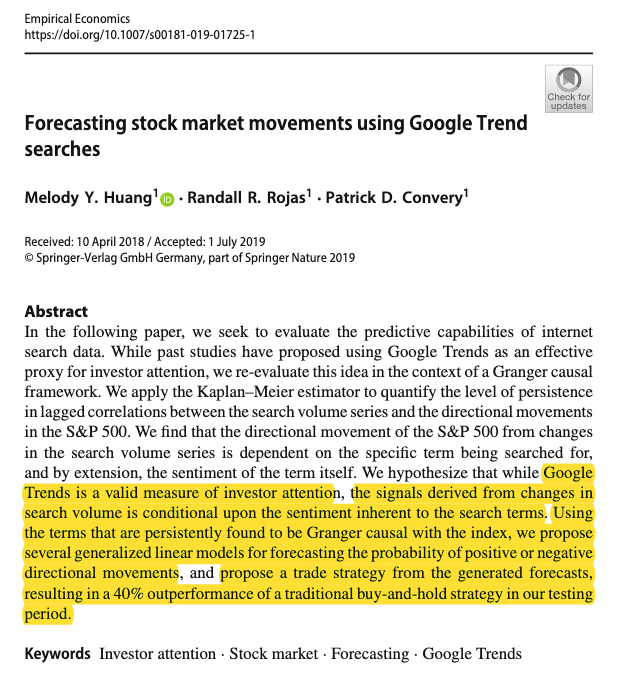

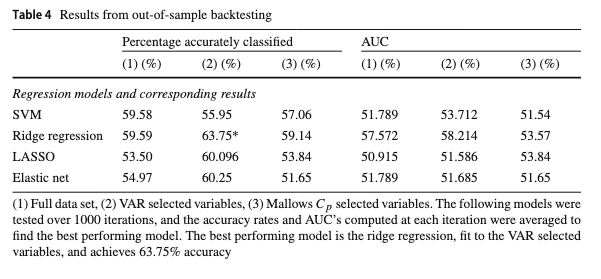

# Our models


## Feature Selection

> 1. All

> 2. Mean decrease impurity (random forest based) - MDI

> 3. Mean decrease accuracy (oos loss of performance; class based) - MDA

> 4. Single feature importance (oos individual feature; reg based) - SFI

> 5. Grenger causality - GRANGER

> 6. Granger causality + Logit - HUANG

> 7. Incremental association Markov boundary - IAMB

> 8. Max-Min Markov boundary - MMMB


## Prediction Models

> 1. Logit

> 2. Ridge regression

> 3. Lasso regression

> 4. Elastic net regression

> 5. Random Forest

> 6. Gradient Boosting

> 7. LSTM neural network (three layer)

## Prediction Setup

> 0. Sample from '2004-01-01' to '2020-12-31'

> 1. Feature selection: '2004-01-01' to '2012-07-03'

> 2. Forecasting: '2012-07-04' to '2020-12-31'

>> a. Random Search

>> b. Predict next year

>> c. Increase sample

# Aggregate prediction results

In [3]:
benchmarks = glob('data/indices/*.csv')
bench_list = []
for b in benchmarks:
    ticker = b.replace('data/indices/', '').replace('.csv', '')
    bench_ret_df = pd.read_csv(b)[3:]
    bench_ret_df.columns = ['date', 'return']
    bench_ret_df = bench_ret_df.melt('date')
    bench_ret_df['model'] = bench_ret_df['ticker'] = ticker
    bench_ret_df['fs'] = 'raw'

    bench_list.append(bench_ret_df)
benchmark_df = pd.concat(bench_list, axis=0)
benchmark_df['value'] = benchmark_df['value'].astype(float)

In [4]:
oos_melt_predictions_df, oos_melt_benchmark_df, oos_melt_auc_df = aggregate_prediction_results(prediction_models=models,
                                                                                               fs_models=fs_methods,
                                                                                               evaluation_start_date='2012-07-03',
                                                                                               evaluation_end_date='2020-12-31',
                                                                                               ticker_names=tickers,
                                                                                               metric_name=metric,
                                                                                               tag='oos',
                                                                                               benchmark_name=benchmark_name)

/Users/dcuoliveira/Documents/Daniel/causal_feature/src/prediction/functions.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  benchmark_df['model'] = benchmark_df['ticker']
/Users/dcuoliveira/Documents/Daniel/causal_feature/src/prediction/functions.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  benchmark_df['fs'] = 'raw'


In [5]:
is_melt_predictions_df, is_melt_benchmark_df, is_melt_auc_df = aggregate_prediction_results(prediction_models=models,
                                                                                            fs_models=fs_methods,
                                                                                            evaluation_start_date='2005-01-03',
                                                                                            evaluation_end_date='2012-07-03',
                                                                                            ticker_names=tickers,
                                                                                            metric_name=metric,
                                                                                            tag='is',
                                                                                            benchmark_name=benchmark_name)

/Users/dcuoliveira/Documents/Daniel/causal_feature/src/prediction/functions.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  benchmark_df['model'] = benchmark_df['ticker']
/Users/dcuoliveira/Documents/Daniel/causal_feature/src/prediction/functions.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  benchmark_df['fs'] = 'raw'


## 1) AUC Analysis

### 1.1) In sample AUC median values

,logit,ridge,lasso,enet,random_forest,lgb,nn3
fs,,,,,,,
all,0.488,0.495,0.491,0.496,0.495,0.488,0.501
sfi,0.564,0.565,0.550,0.594,0.520,0.517,0.531
mdi,0.508,0.503,0.510,0.511,0.505,0.496,0.502
mda,0.504,0.505,0.495,0.506,0.505,0.503,0.505
granger,0.548,0.548,0.553,0.550,0.518,0.514,0.525
huang,0.567,0.567,0.567,0.568,0.531,0.530,0.539
IAMB,0.618,0.618,0.618,0.618,0.556,0.547,0.579
MMMB,0.564,0.564,0.564,0.564,0.533,0.532,0.516


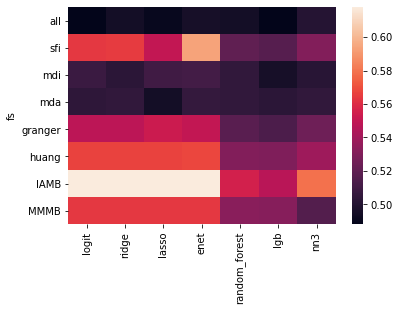

In [6]:
is_auc_df = is_melt_auc_df.pivot_table(index=['fs'], columns=['model'], values=['isauc'], aggfunc='median')
simple_cols = [c[1] for c in is_auc_df.columns]
is_auc_df.columns = simple_cols
is_auc_df = is_auc_df.loc[fs_methods][models].apply(lambda x: np.round(x,3))

display(Markdown("### 1.1) In sample AUC median values"))
display(HTML(is_auc_df.to_html()))
sns.heatmap(is_auc_df);

### 1.2) Out of sample AUC median values

,logit,ridge,lasso,enet,random_forest,lgb,nn3
fs,,,,,,,
all,0.500,0.499,0.501,0.504,0.495,0.501,0.495
sfi,0.508,0.500,0.503,0.504,0.485,0.496,0.500
mdi,0.497,0.501,0.503,0.496,0.492,0.491,0.498
mda,0.504,0.502,0.503,0.498,0.501,0.496,0.498
granger,0.505,0.505,0.506,0.506,0.495,0.497,0.498
huang,0.501,0.501,0.501,0.501,0.496,0.501,0.496
IAMB,0.505,0.505,0.504,0.505,0.501,0.496,0.504
MMMB,0.492,0.492,0.492,0.492,0.491,0.496,0.496


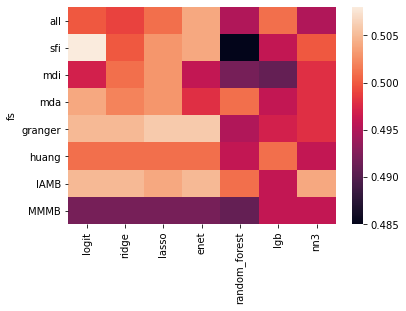

In [7]:
oos_auc_df = oos_melt_auc_df.pivot_table(index=['fs'], columns=['model'], values=['oosauc'], aggfunc='median')
simple_cols = [c[1] for c in oos_auc_df.columns]
oos_auc_df.columns = simple_cols
oos_auc_df = oos_auc_df.loc[fs_methods][models].apply(lambda x: np.round(x,3))

display(Markdown("### 1.2) Out of sample AUC median values"))
display(HTML(oos_auc_df.to_html()))
sns.heatmap(oos_auc_df);

### 1.3) Out of sample AUC distribution across models

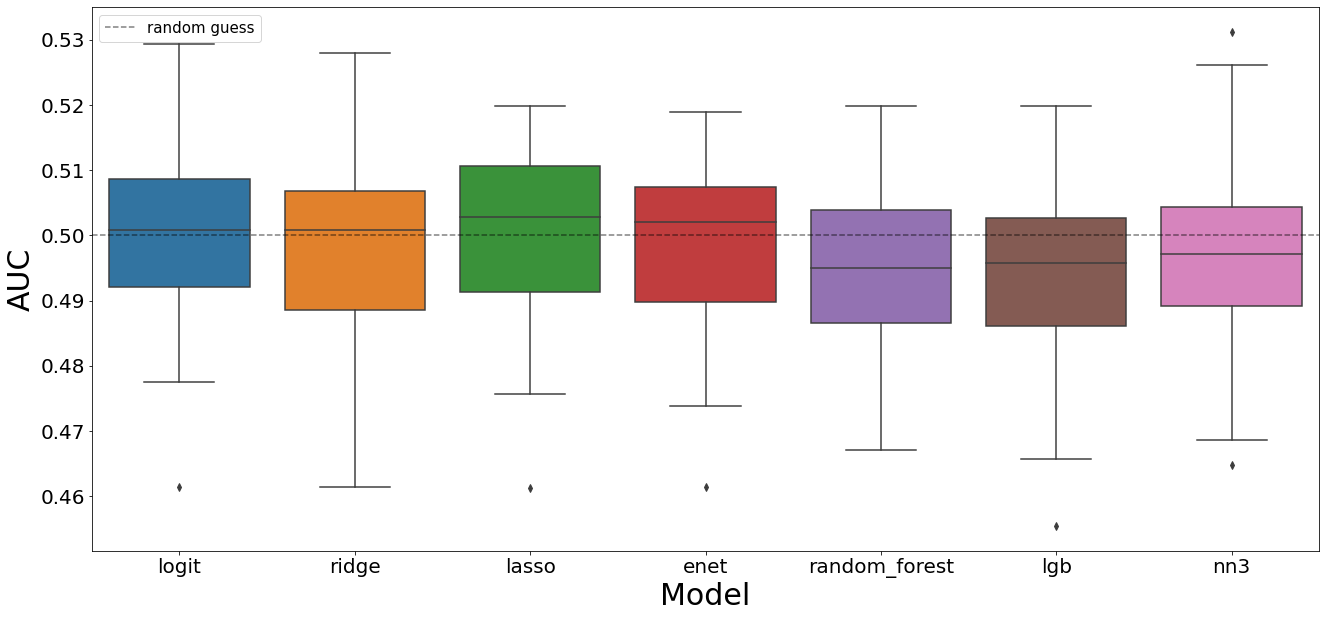

In [8]:
display(Markdown("### 1.3) Out of sample AUC distribution across models"))

fig, ax = plt.subplots(figsize=(22,10))
sns.boxplot(x="model", y='oosauc',data=oos_melt_auc_df, ax=ax, order=models);
ax.set_ylabel("AUC", fontsize=30);
ax.set_xlabel("Model", fontsize=30);
ax.axhline(y=0.50, color='k', linestyle='--', alpha=0.5, label="random guess");
ax.tick_params(axis="x", labelsize=20);
ax.tick_params(axis="y", labelsize=20);
ax.legend(loc="best",fontsize=15);
fig.savefig('img/oos_auc_models_distr.png')

### 1.4) Out of sample AUC distribution across feature selection methods

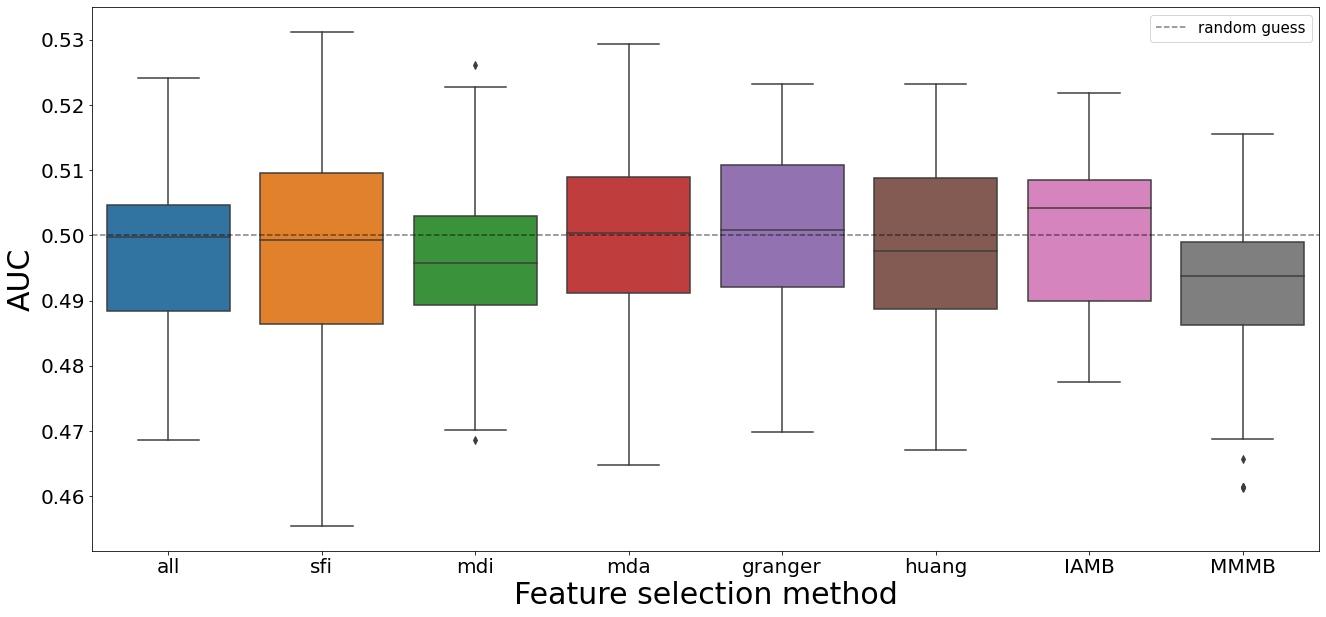

In [9]:
display(Markdown("### 1.4) Out of sample AUC distribution across feature selection methods"))

fig, ax = plt.subplots(figsize=(22,10))
sns.boxplot(x="fs", y='oosauc',data=oos_melt_auc_df, ax=ax, order=fs_methods);
ax.set_ylabel("AUC", fontsize=30);
ax.set_xlabel("Feature selection method", fontsize=30);
ax.axhline(y=0.50, color='k', linestyle='--', alpha=0.5, label="random guess");
ax.tick_params(axis="x", labelsize=20);
ax.tick_params(axis="y", labelsize=20);
ax.legend(loc="best",fontsize=15);
fig.savefig('img/oos_auc_fs_methods_distr.png')

### 1.5) Out of sample AUC distribution across models (SPX index only)

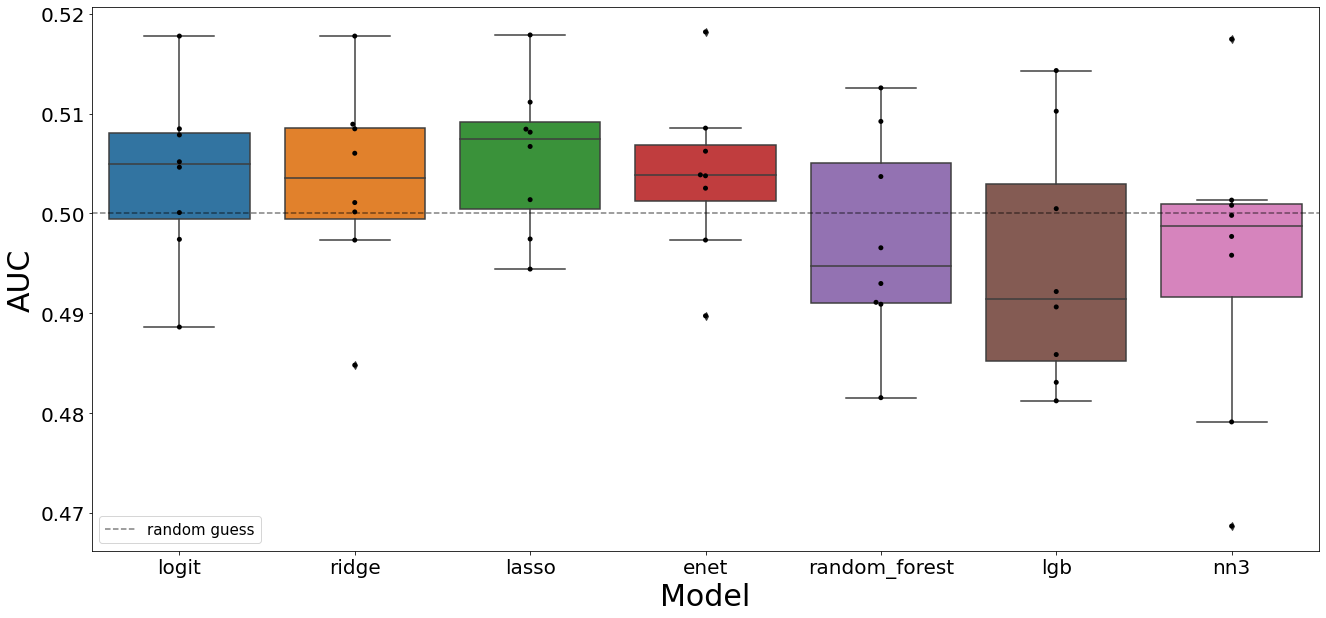

In [10]:
oos_spx_auc_df = oos_melt_auc_df[oos_melt_auc_df["ticker"] == "SPX Index"].reset_index(drop=True)


display(Markdown("### 1.5) Out of sample AUC distribution across models (SPX index only)"))

fig, ax = plt.subplots(figsize=(22,10))
sns.boxplot(x="model", y='oosauc',
            data=oos_spx_auc_df, ax=ax, order=models);
sns.swarmplot(x="model", y='oosauc',
              data=oos_spx_auc_df,ax=ax,
              color="k",order=models)

ax.set_ylabel("AUC", fontsize=30);
ax.set_xlabel("Model", fontsize=30);
ax.axhline(y=0.50, color='k', linestyle='--', alpha=0.5, label="random guess");
ax.tick_params(axis="x", labelsize=20);
ax.tick_params(axis="y", labelsize=20);
ax.legend(loc="best",fontsize=15);
fig.savefig('img/oos_auc_models_distr_spx.png')


### 1.6) Out of sample AUC distribution across feature selection methods (SPX index only)

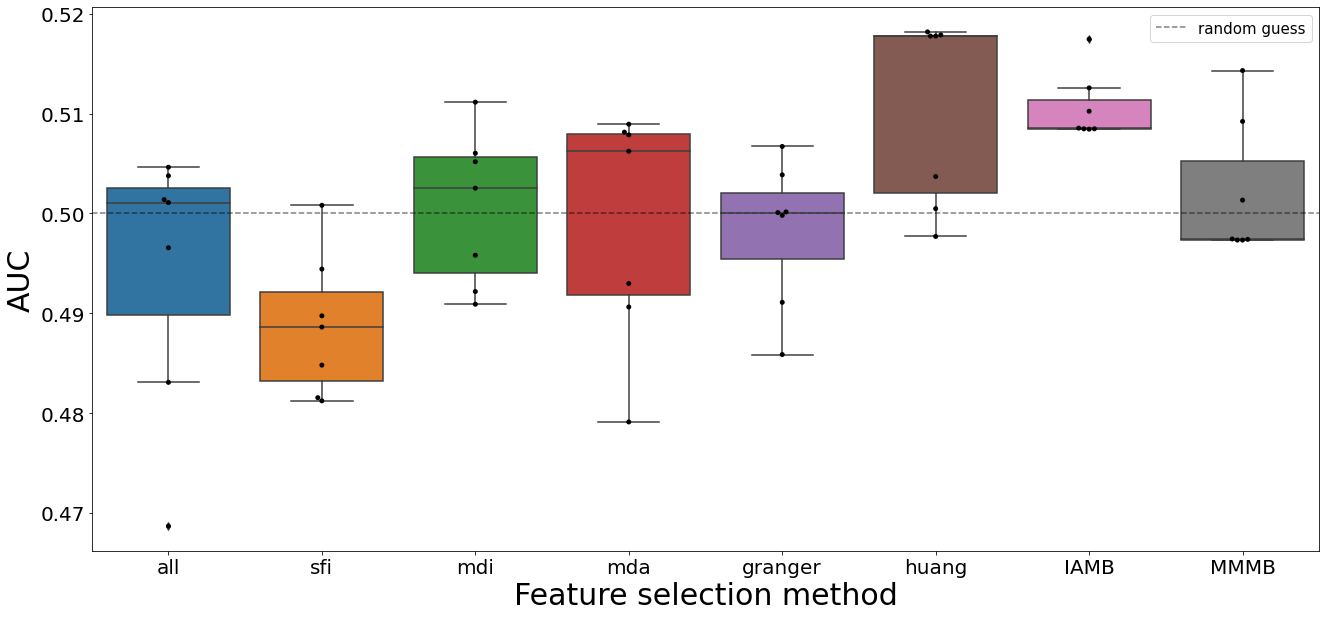

In [11]:
display(Markdown("### 1.6) Out of sample AUC distribution across feature selection methods (SPX index only)"))

fig, ax = plt.subplots(figsize=(22,10))
sns.boxplot(x="fs", y='oosauc',data=oos_spx_auc_df, ax=ax, order=fs_methods);
sns.swarmplot(x="fs", y='oosauc',
              data=oos_spx_auc_df,ax=ax,
              color="k",order=fs_methods)
ax.set_ylabel("AUC", fontsize=30);
ax.set_xlabel("Feature selection method", fontsize=30);
ax.axhline(y=0.50, color='k', linestyle='--', alpha=0.5, label="random guess");
ax.tick_params(axis="x", labelsize=20);
ax.tick_params(axis="y", labelsize=20);
ax.legend(loc="best",fontsize=15);
fig.savefig('img/oos_auc_fs_methods_distr_spx.png')

## 2) Sharpe ratio

### 2.1) Out of sample Sharpe values median values (average benchmark 0.604)

,logit,ridge,lasso,enet,random_forest,lgb,nn3
fs,,,,,,,
all,0.143,-0.126,0.030,0.334,0.605,0.129,0.669
sfi,0.064,0.210,0.006,0.155,0.661,0.011,0.638
mdi,0.025,0.070,0.100,0.218,0.713,-0.018,0.657
mda,0.097,0.081,0.143,0.228,0.714,0.054,0.509
granger,0.396,0.396,0.664,0.480,0.635,0.140,0.688
huang,0.716,0.716,0.714,0.684,0.717,0.367,0.708
IAMB,0.172,0.172,0.177,0.160,0.620,0.256,0.503
MMMB,0.616,0.616,0.640,0.625,0.690,0.575,0.641


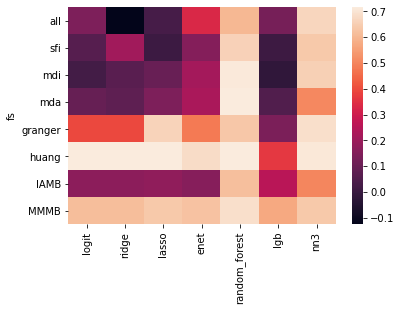

In [12]:
oos_pred_ret_df, oos_pred_pos_df = gen_strat_positions_and_ret_from_pred(predictions_df=oos_melt_predictions_df,
                                                                         class_threshold=0.5,
                                                                         target_asset_returns=benchmark_df)
ret_all_df = pd.concat([oos_pred_ret_df, benchmark_df], axis=0)
sr_rank_df, sr_tb_df, sr_agg_df = sharpe_ratio_tb(returns_df=ret_all_df.dropna(),
                                                  level_to_subset='fs',
                                                  rf=.0)

ret_all_df = pd.concat([oos_pred_ret_df, benchmark_df], axis=0)
sr_rank_df, sr_tb_df, sr_agg_df = sharpe_ratio_tb(returns_df=ret_all_df.dropna(),
                                                  level_to_subset='fs',
                                                  rf=.0)

sr_df = sr_rank_df.reset_index()
sr_df_raw = sr_df.loc[sr_df["fs"]=="raw"].reset_index(drop=True)
sr_df = sr_df.loc[sr_df["fs"]!="raw"].reset_index(drop=True)
sr_df_spx = sr_df.loc[sr_df["ticker"]=="SPX Index"].reset_index(drop=True)

average_sr = sr_df_raw["sharpe ratio"].mean()

# Sanity Check
assert oos_melt_auc_df.shape[0] == sr_df.shape[0]

simple_sr_df = sr_df.pivot_table(index=['fs'], columns=['model'], values=['sharpe ratio'], aggfunc='median')
simple_cols = [c[1] for c in simple_sr_df.columns]
simple_sr_df.columns = simple_cols
simple_sr_df = simple_sr_df.loc[fs_methods][models].apply(lambda x: np.round(x,3))

display(Markdown("### 2.1) Out of sample Sharpe values median values (average benchmark {:.3f})".format(average_sr)))
display(HTML(simple_sr_df.to_html()))
sns.heatmap(simple_sr_df);

### 2.2) Out of sample Sharpe ratio distribution across models

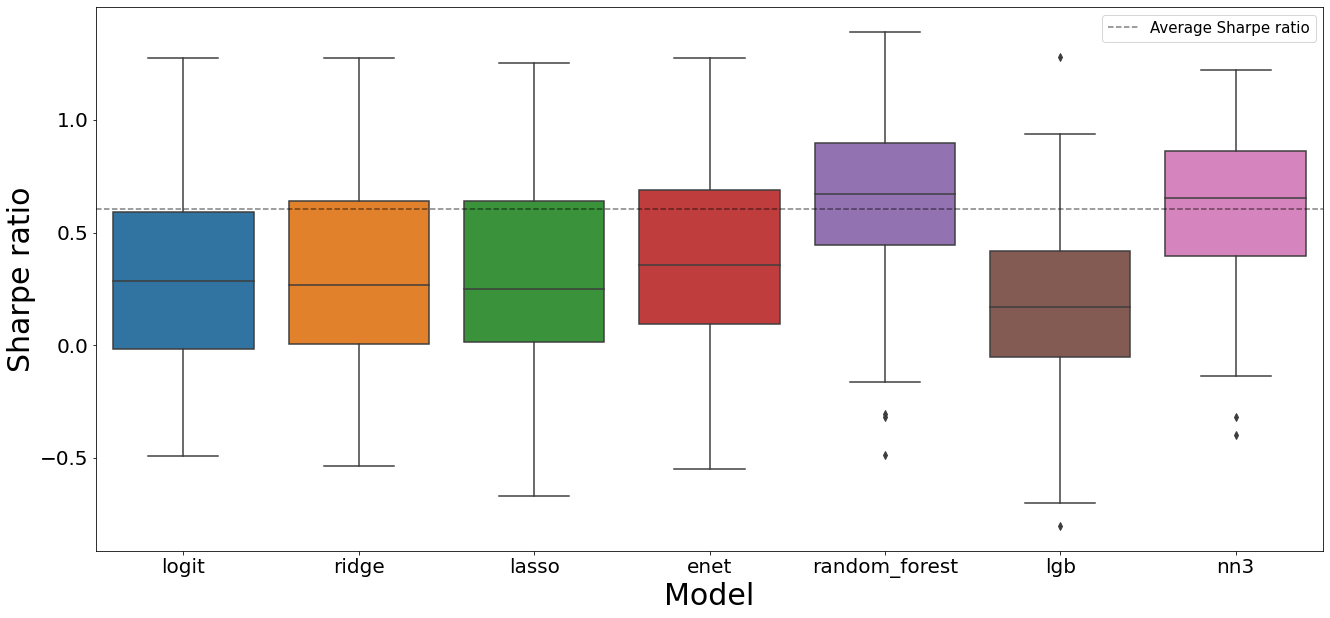

In [13]:
display(Markdown("### 2.2) Out of sample Sharpe ratio distribution across models"))

fig, ax = plt.subplots(figsize=(22,10))
sns.boxplot(x="model", y='sharpe ratio',data=sr_df, ax=ax, order=models);
ax.set_ylabel("Sharpe ratio", fontsize=30);
ax.set_xlabel("Model", fontsize=30);
ax.axhline(y=average_sr,
           color='k',
           linestyle='--',
           alpha=0.5, label="Average Sharpe ratio");
ax.tick_params(axis="x", labelsize=20);
ax.tick_params(axis="y", labelsize=20);
ax.legend(loc="best",fontsize=15);
fig.savefig('img/oos_sr_models_distr.png')

### 2.3) Out of sample Sharpe ratio distribution across feature selection methods

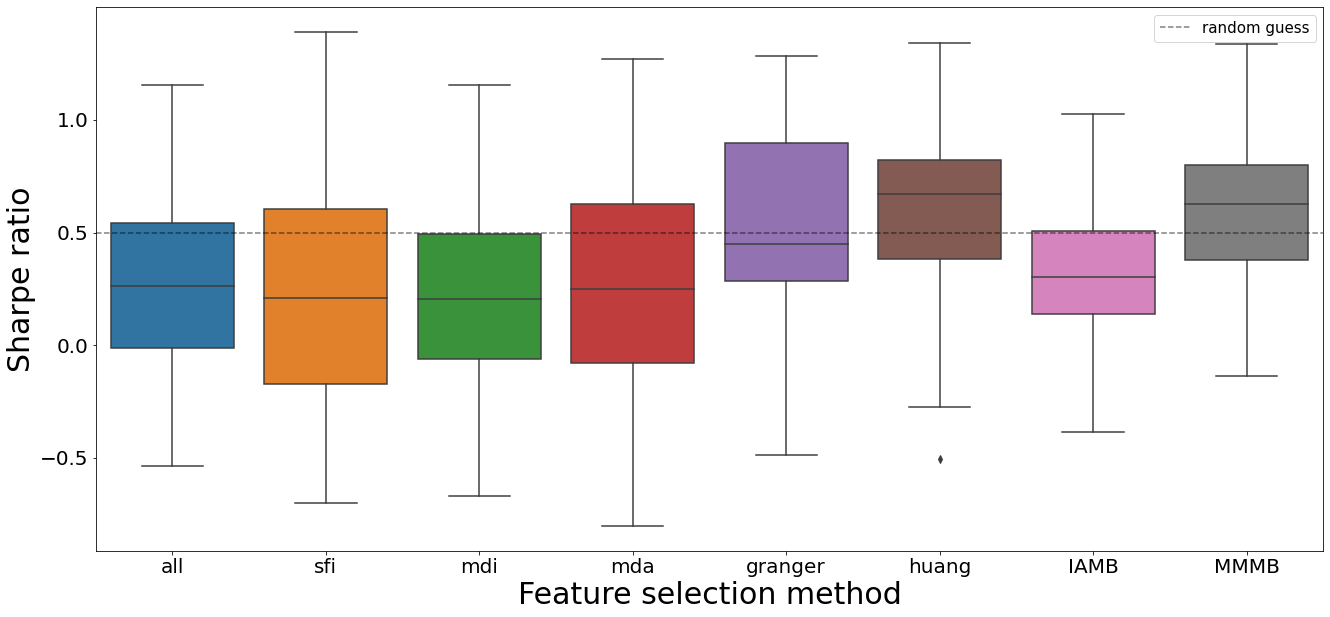

In [14]:
display(Markdown("### 2.3) Out of sample Sharpe ratio distribution across feature selection methods"))

fig, ax = plt.subplots(figsize=(22,10))
sns.boxplot(x="fs", y='sharpe ratio',data=sr_df, ax=ax, order=fs_methods);
ax.set_ylabel("Sharpe ratio", fontsize=30);
ax.set_xlabel("Feature selection method", fontsize=30);
ax.axhline(y=0.50, color='k', linestyle='--', alpha=0.5, label="random guess");
ax.tick_params(axis="x", labelsize=20);
ax.tick_params(axis="y", labelsize=20);
ax.legend(loc="best",fontsize=15);
fig.savefig('img/oos_sr_fs_methods_distr.png')

### 2.4) Out of sample Sharpe ratio distribution across models (SPX Index only)

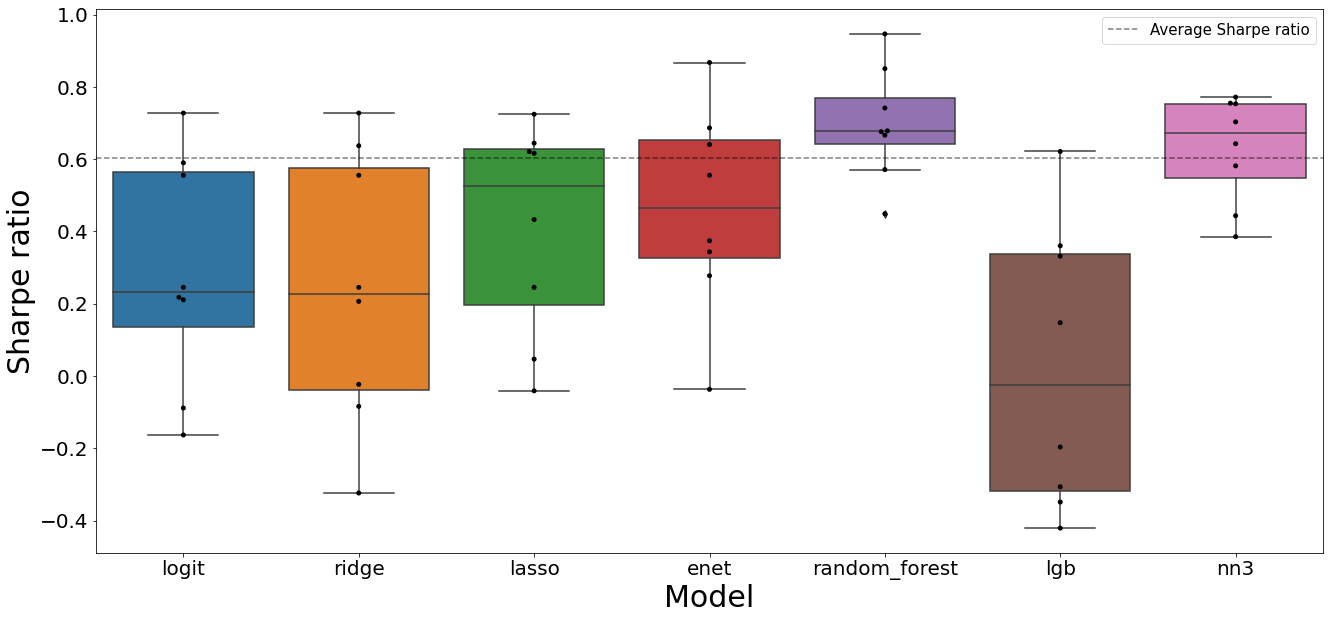

In [15]:
display(Markdown("### 2.4) Out of sample Sharpe ratio distribution across models (SPX Index only)"))

fig, ax = plt.subplots(figsize=(22,10))
sns.boxplot(x="model", y='sharpe ratio',data=sr_df_spx, ax=ax, order=models);
sns.swarmplot(x="model", y='sharpe ratio',
              data=sr_df_spx,ax=ax,
              color="k",order=models)
ax.set_ylabel("Sharpe ratio", fontsize=30);
ax.set_xlabel("Model", fontsize=30);
ax.axhline(y=average_sr,
           color='k',
           linestyle='--',
           alpha=0.5, label="Average Sharpe ratio");
ax.tick_params(axis="x", labelsize=20);
ax.tick_params(axis="y", labelsize=20);
ax.legend(loc="best",fontsize=15);
fig.savefig('img/oos_sr_models_distr_spx.png')

### 2.5) Out of sample Sharpe ratio distribution across models (SPX Index only)

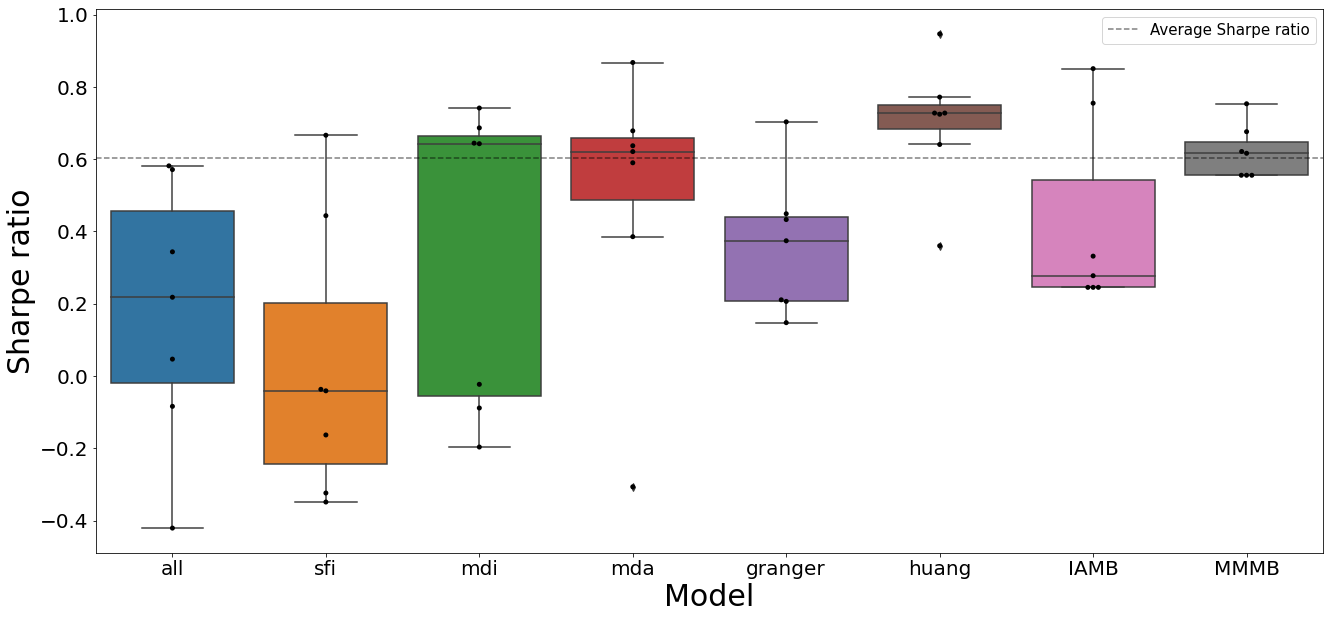

In [16]:
display(Markdown("### 2.5) Out of sample Sharpe ratio distribution across models (SPX Index only)"))

fig, ax = plt.subplots(figsize=(22,10))
sns.boxplot(x="fs", y='sharpe ratio',data=sr_df_spx, ax=ax, order=fs_methods);
sns.swarmplot(x="fs", y='sharpe ratio',
              data=sr_df_spx,ax=ax,
              color="k",order=fs_methods)
ax.set_ylabel("Sharpe ratio", fontsize=30);
ax.set_xlabel("Model", fontsize=30);
ax.axhline(y=average_sr,
           color='k',
           linestyle='--',
           alpha=0.5, label="Average Sharpe ratio");
ax.tick_params(axis="x", labelsize=20);
ax.tick_params(axis="y", labelsize=20);
ax.legend(loc="best",fontsize=15);
fig.savefig('img/oos_sr_fs_methods_distr_spx.png')

## 3) Cummulative returns

### Todo

In [21]:
summary_oos_pred_ret_df = oos_pred_ret_df.loc[oos_pred_ret_df['ticker']==ticker]
summary_benchmark_df = benchmark_df.loc[benchmark_df['ticker']==ticker]

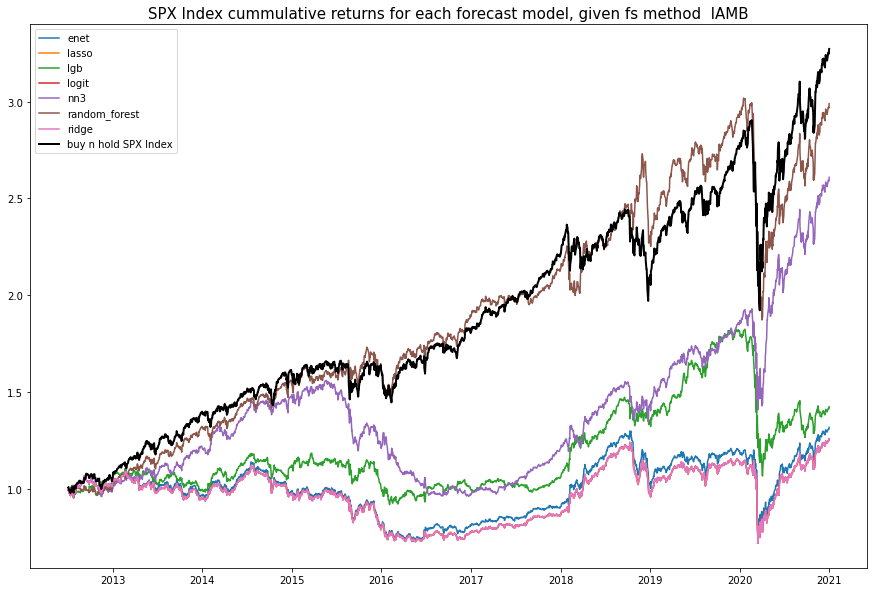

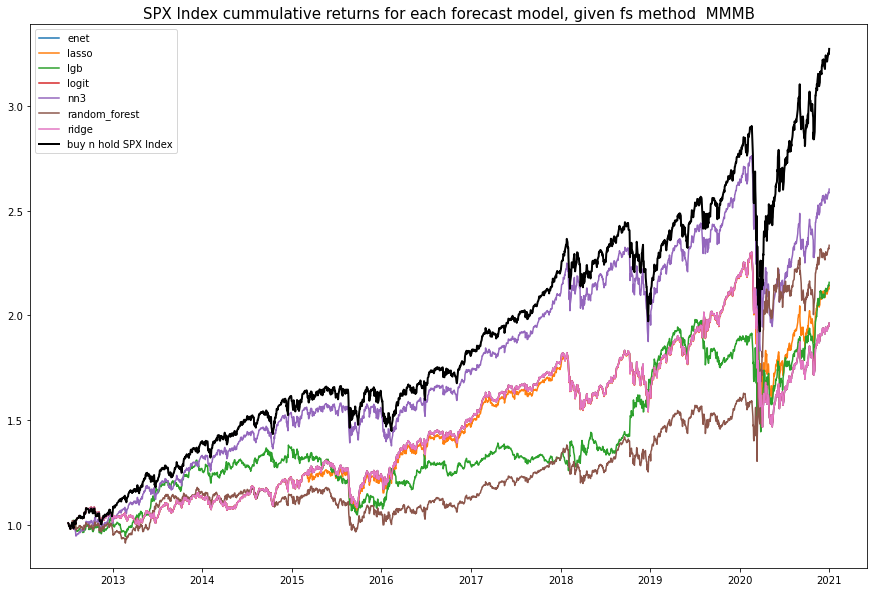

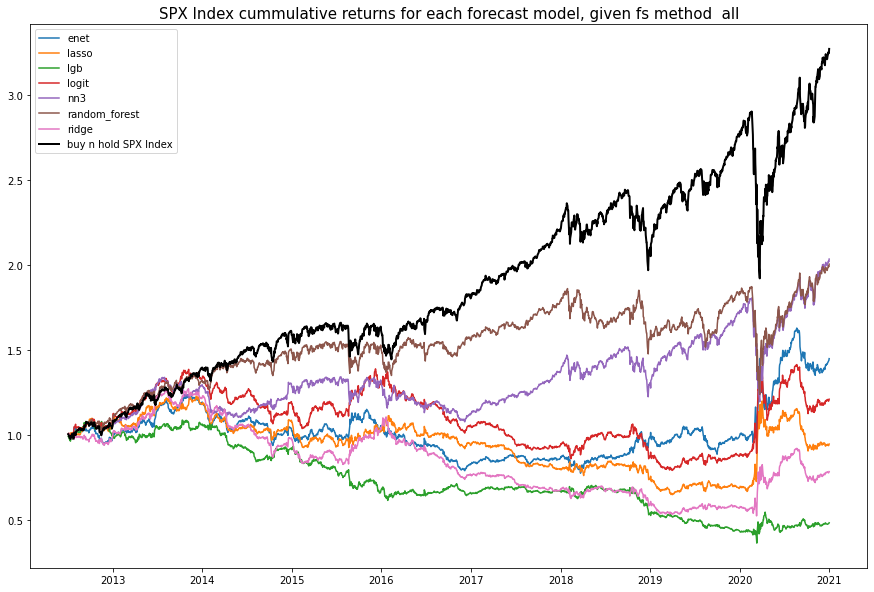

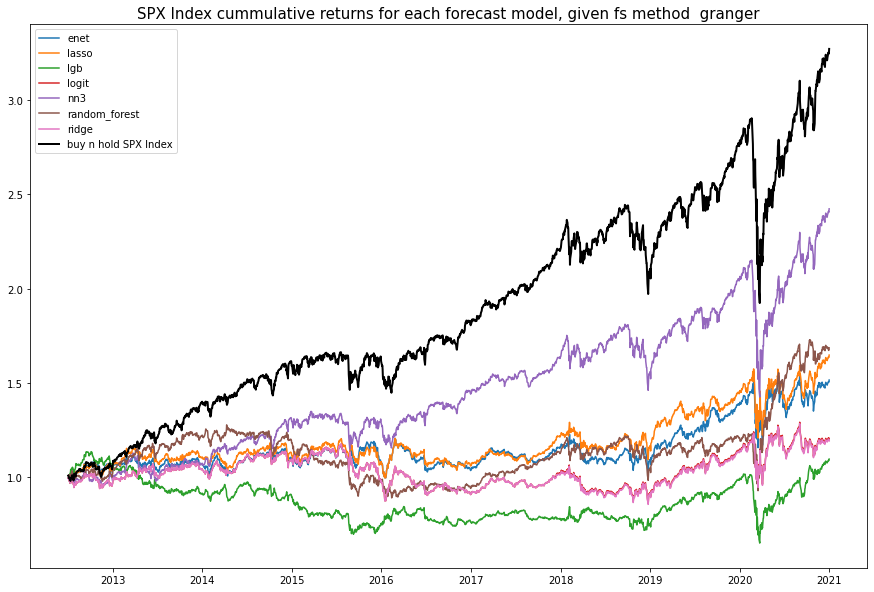

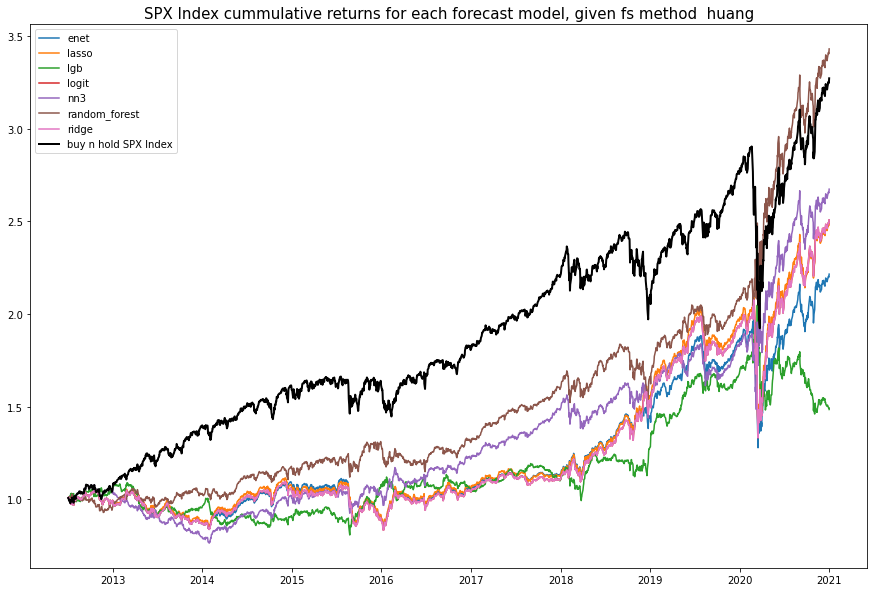

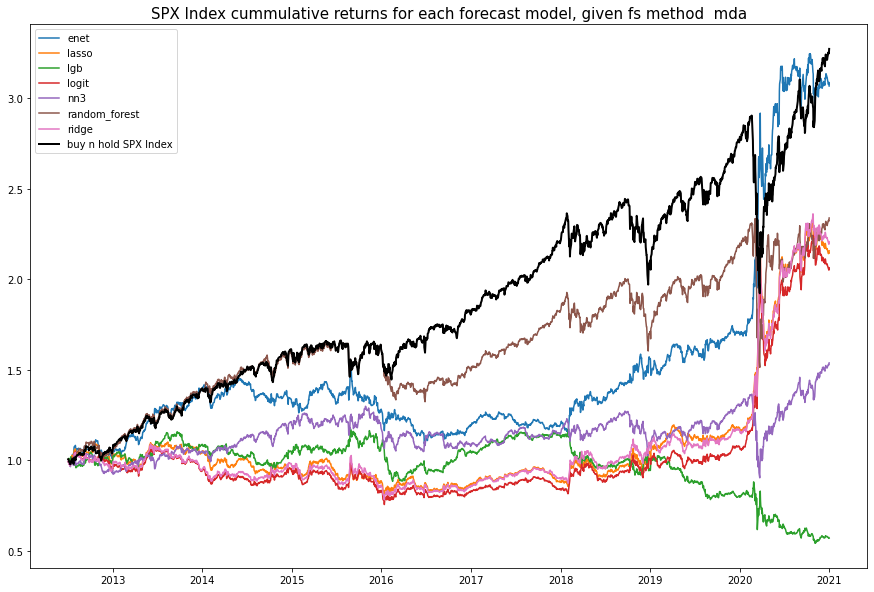

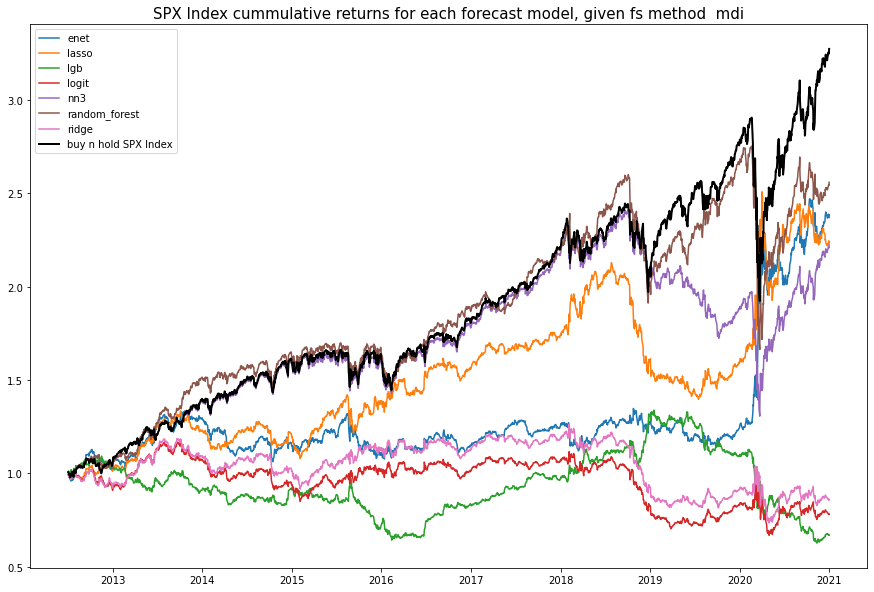

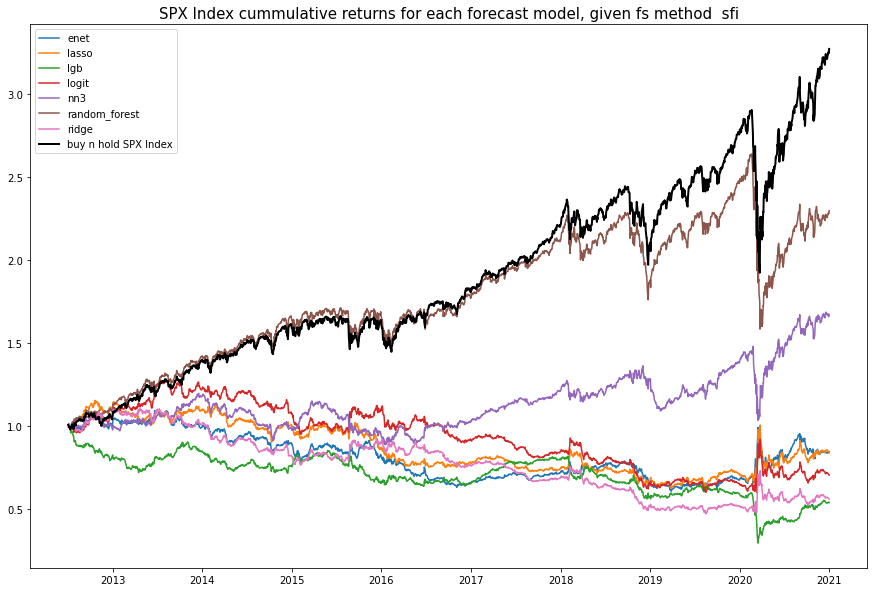

In [83]:
ticker = 'SPX Index'

for key1 in summary_oos_pred_ret_df['fs'].unique():
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.set_title(label=ticker + ' cummulative returns for each forecast model, given fs method  ' + key1, fontsize=15)

    for key2 in summary_oos_pred_ret_df['model'].unique():
        loop_df = summary_oos_pred_ret_df.loc[(summary_oos_pred_ret_df['fs'] == key1)&
                                              (summary_oos_pred_ret_df['model'] == key2)&
                                              (summary_oos_pred_ret_df['ticker'] == ticker)]
        ax.plot(pd.to_datetime(loop_df['date']), (1+loop_df['value']/100).cumprod(), label=key2)

    bench = summary_benchmark_df.loc[(summary_benchmark_df['ticker']==ticker)&(summary_benchmark_df['date'] >= loop_df['date'].iloc[0])]
    ax.plot(pd.to_datetime(bench['date']), (1+bench['value']/100).cumprod(), label='buy n hold ' + ticker, color='black', linewidth=2)
    plt.legend(loc='best', fontsize=10)    
    plt.show()

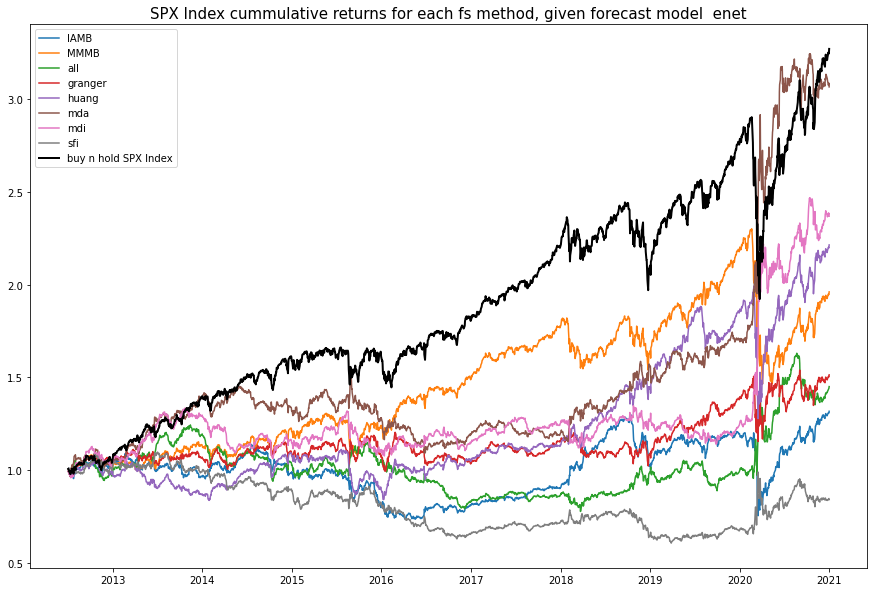

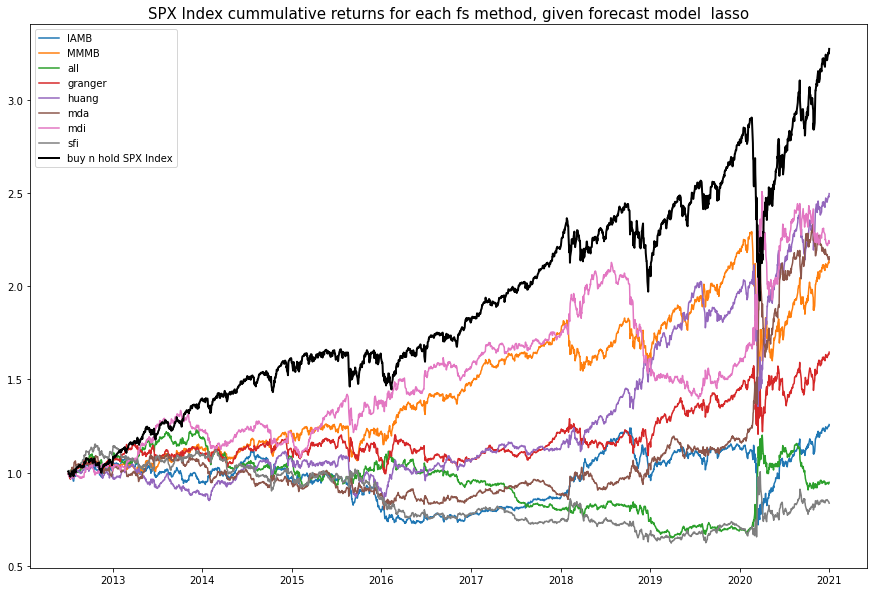

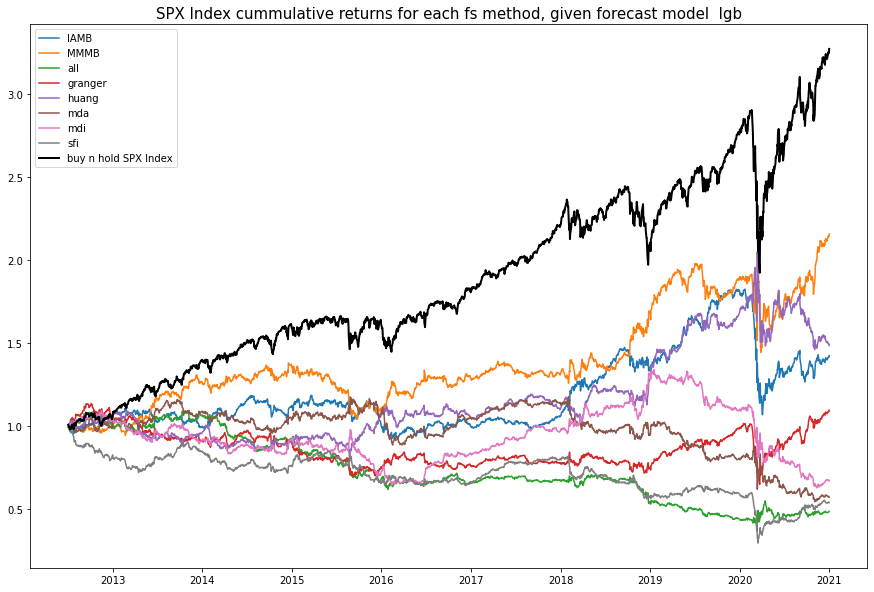

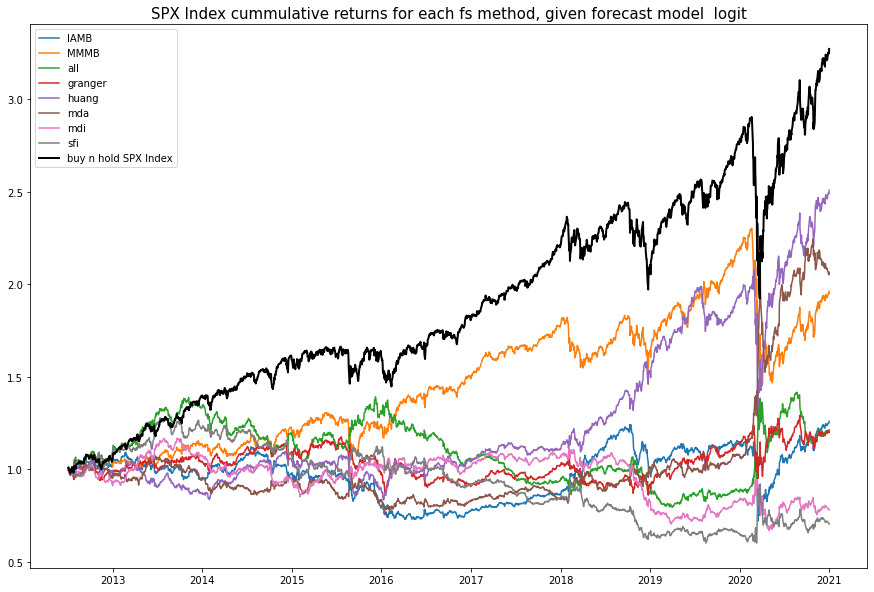

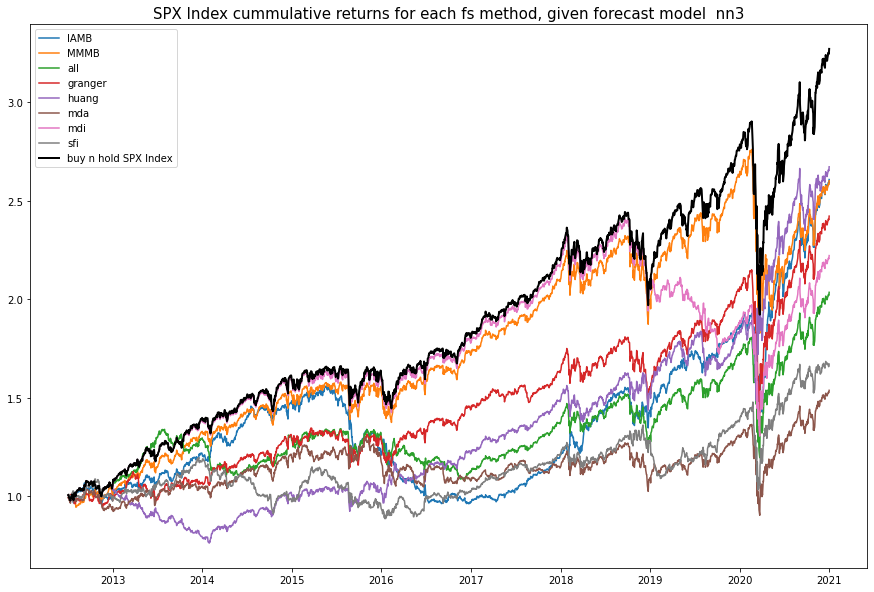

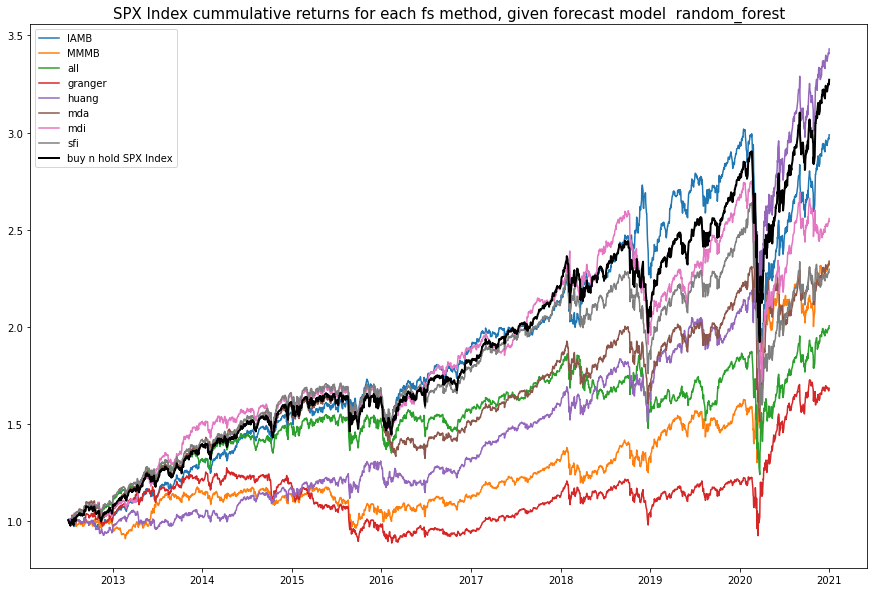

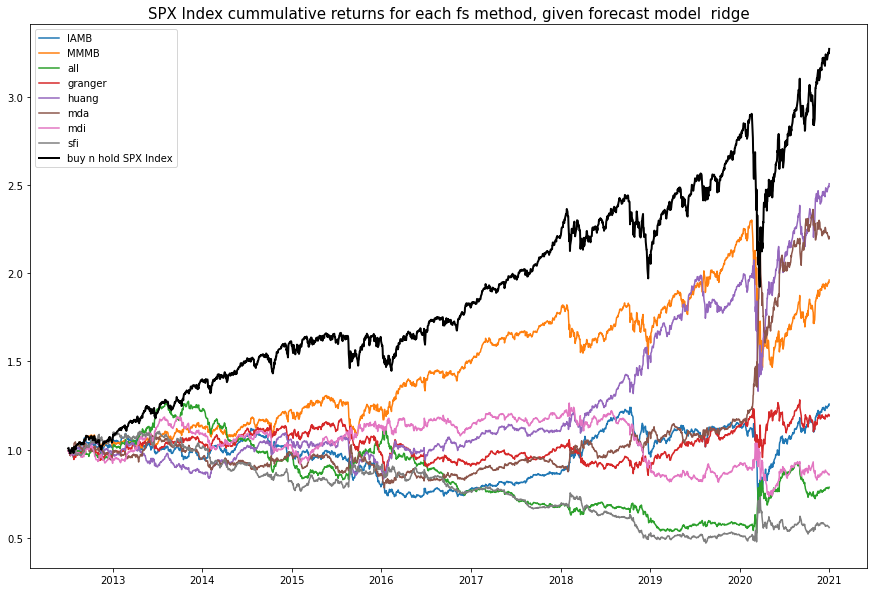

In [85]:
for key1 in summary_oos_pred_ret_df['model'].unique():
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.set_title(label=ticker + ' cummulative returns for each fs method, given forecast model  ' + key1, fontsize=15)

    for key2 in summary_oos_pred_ret_df['fs'].unique():
        loop_df = summary_oos_pred_ret_df.loc[(summary_oos_pred_ret_df['model'] == key1)&
                                              (summary_oos_pred_ret_df['fs'] == key2)&
                                              (summary_oos_pred_ret_df['ticker'] == ticker)]
        ax.plot(pd.to_datetime(loop_df['date']), (1+loop_df['value']/100).cumprod(), label=key2)

    bench = summary_benchmark_df.loc[(summary_benchmark_df['ticker']==ticker)&(summary_benchmark_df['date'] >= loop_df['date'].iloc[0])]
    ax.plot(pd.to_datetime(bench['date']), (1+bench['value']/100).cumprod(), label='buy n hold ' + ticker, color='black', linewidth=2)
    plt.legend(loc='best', fontsize=10)    
    plt.show()

In [17]:
tot_time = time() - init
tot_time = tot_time / 60
print("notebook time = {:.3f} (minutes)".format(tot_time))

notebook time = 1.312 (minutes)
